In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import itertools
import random
import librosa

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

## Question 1

### Data Construction

In [4]:
def imagePatches(image): # image = 28 x 28
    all_patch = []
    all_patch_vector = []
    for i in range(4):
        for j in range(4):
            patch = image[i*7:i*7+7, j*7:j*7+7]
            patch_vector = patch.flatten()
            all_patch.append(patch)
            all_patch_vector.append(patch_vector)
    return all_patch, all_patch_vector

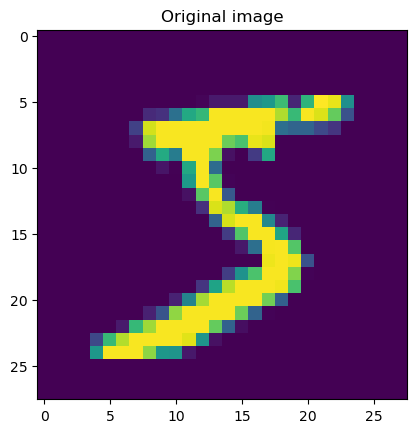

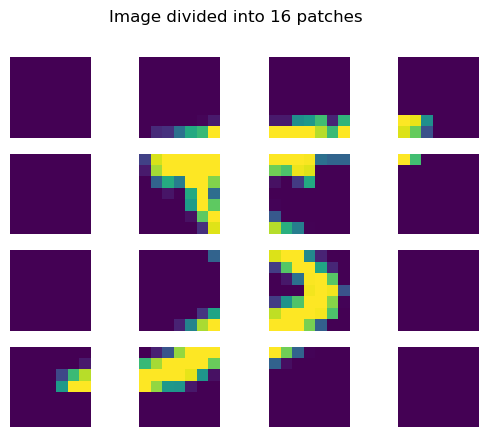

In [5]:
plt.figure()
ax=plt.subplot2grid((1, 1), (0, 0))
ax.imshow(X_train[0, :, :])
plt.title('Original image')

patched_images, vectors = imagePatches(X_train[0, :, :])

plt.figure()
plt.suptitle('Image divided into 16 patches')
for i in range(4):
    for j in range(4):
        ax=plt.subplot2grid((4, 4), (i, j))
        ax.imshow(patched_images[i*4+j])
        plt.axis('off')


In [6]:
# i = 0
train_data = []
for image in X_train:
    _, vectors = imagePatches(image)
    train_data.append(vectors)
    # i+=1
    # print(f"{i}", end='\r')
train_data = np.array(train_data)
print(np.shape(train_data))

test_data = []
for image in X_test:
    _, vectors = imagePatches(image)
    test_data.append(vectors)
    
test_data = np.array(test_data)
print(np.shape(test_data))


(60000, 16, 49)
(10000, 16, 49)


### Model 

In [7]:
class CustomLSTMModel(tf.keras.Model):
    def __init__(self):
        super(CustomLSTMModel, self).__init__()
        self.lstm_units = 64
        self.time_steps = None 
        self.input_features = 49

        self.lstm_layer = tf.keras.layers.LSTM(units=self.lstm_units, return_sequences=True, return_state=True)
        self.dense_layer = tf.keras.layers.Dense(49, activation='sigmoid')

    def call(self, inputs, initial_state=None):
        if initial_state is None:
            initial_state = [tf.zeros((tf.shape(inputs)[0], self.lstm_units)),
                             tf.zeros((tf.shape(inputs)[0], self.lstm_units))]

        lstm_output, state_h, state_c = self.lstm_layer(inputs, initial_state=initial_state)
        output = self.dense_layer(lstm_output)
        
        x = [output, state_h, state_c]

        return x 
    


In [ ]:
model = CustomLSTMModel()

learning_rate = 0.005
batch_size = 200
num_epochs = 100
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)
train_loss = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
train_data1 = train_data[:, 0:15, :]
train_label1 = train_data[:, 1:16, :]
val_data1 = test_data[:, 0:15, :]
val_label1 = test_data[:, 1:16, :]

for epoch in range(num_epochs):

    train_running_loss = 0.0

    for i in range(0, len(train_data1), batch_size):
        batch_images = train_data1[i:i+batch_size]
        batch_labels = train_label1[i:i+batch_size]
        with tf.GradientTape() as tape:
            output, state_h, state_c = model(batch_images)
            loss = tf.keras.losses.MeanSquaredError()(batch_labels, output)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_running_loss += loss.numpy()

    train_loss[epoch] = train_running_loss / (len(train_data1) // batch_size)
    
    val_running_loss = 0.0
    
    for i in range(0, len(val_data1), batch_size):
        val_images = val_data1[i:i+batch_size]
        val_labels = val_label1[i:i+batch_size]
        val_output, _, _ = model(val_images)
        val_loss_value = tf.keras.losses.MeanSquaredError()(val_labels, val_output)
        val_running_loss += val_loss_value.numpy()

    val_loss[epoch] = val_running_loss / (len(val_data1) // batch_size)

    print('Epoch = ', epoch, 'training loss {:.4f}'.format(train_loss[epoch]),'validation loss {:.4f}'.format(val_loss[epoch]))

Text(0, 0.5, 'Loss')

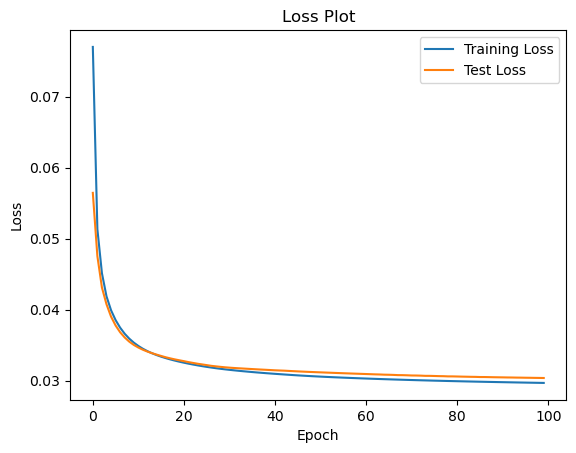

In [9]:
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.title('Loss Plot')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [21]:
def imageReconstruction(test_image):
    # giving the model upper half of the image as an input 
    # get the predicted first eight patches 

    upper_half = tf.reshape(test_image, (1, 8, 49))
    output, final_state_h, final_state_c = model(upper_half)

    # provide the last predicted eight patch to predict the ninth patch 
    # and do this for the last eight patches from patch 9 to patch 16

    lower_half =  np.zeros((1, 0, 49))
    for i in range(8):
        X = tf.reshape(output[:, -1, :], (1, 1, 49))
        output, final_state_h, final_state_c = model(X, initial_state=[final_state_h, final_state_c])
        lower_half = np.concatenate([lower_half, output], axis=1)

    # Reshape to have each patch in a row for lower and upper half of the image 
    # Upper half of the image is the original image 
    # Lower half of the image is the prediction from the model

    upper_half = np.reshape(upper_half, (8, 49))
    lower_half = np.reshape(lower_half, (8, 49))
    
    # lower_half = [lower_half[7,:], lower_half[0:7,:]]
    lower_half = np.roll(lower_half, shift=1, axis=0)


    # convert each row of the image which is flattened verrsion back into 7, 7 patch  
    # Convert both the upper and lower images

    upper_half_final = np.zeros((8, 7, 7))
    for i in range(8):
        upper_half_final[i, :, :] = np.reshape(upper_half[i, :], (7, 7))

    lower_half_final = np.zeros((8, 7, 7))
    for i in range(8):
        lower_half_final[i, :, :] = np.reshape(lower_half[i, :], (7, 7))

    # Arrange the 8 patches of upper image in a order and store them into a matrix of 14x28 
    # This is the upper half of the image 
    # Repeat the steps for the lower half to arrange it into lower 14x28 matrix

    recons_img_upper = np.zeros((14, 28))
    for i in range(2):
        for j in range(4):
            recons_img_upper[i*7:i*7+7, j*7:j*7+7] = upper_half_final[i*4 + j]

    recons_img_lower = np.zeros((14, 28))
    for i in range(2):
        for j in range(4):
            recons_img_lower[i*7:i*7+7, j*7:j*7+7] = lower_half_final[i*4 + j]

    # combine the upper and lower images into the reconstructed image 

    recons_img =  np.vstack((recons_img_upper, recons_img_lower))
    
    return recons_img

Text(0.5, 1.0, 'Reconstructed image')

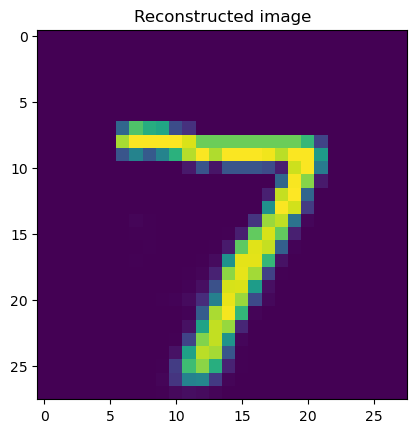

In [22]:
# Ploting the reconstructed image 

recons_img = imageReconstruction(test_data[0,0:8,:])

plt.figure()
ax=plt.subplot2grid((1, 1), (0, 0))
ax.imshow(recons_img)
plt.title('Reconstructed image')


In [23]:
# Dataset containing ten image from each class
# Reconstructed images are based on this dataset

label_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
label_limit = 10
X_test_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

for i, label in enumerate(Y_test):
    if label_count[label] < label_limit:
        X_test_dict[label].append(X_test[i])
        label_count[label] += 1

X_test_reduced = np.vstack((X_test_dict[0], X_test_dict[1], X_test_dict[2], 
                            X_test_dict[3], X_test_dict[4], X_test_dict[5],
                            X_test_dict[6], X_test_dict[7], X_test_dict[8],
                            X_test_dict[9]))

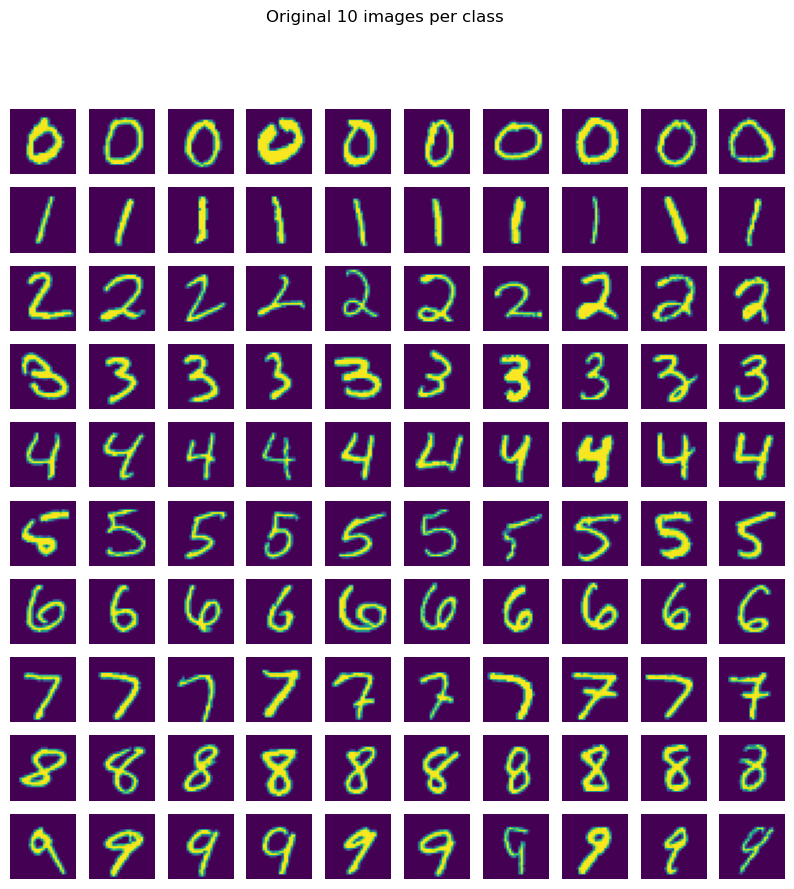

In [28]:
plt.figure(figsize=(10, 10))
plt.suptitle('Original 10 images per class')

for i in range(10):
    for j in range(10):
        ax=plt.subplot2grid((10, 10), (i, j))
        ax.imshow(X_test_reduced[i*10+j])
        plt.axis('off')

In [25]:
test_data_reduced = []
for image in X_test_reduced:
    _, vectors = imagePatches(image)
    test_data_reduced.append(vectors)
    
test_data_reduced = np.array(test_data_reduced)

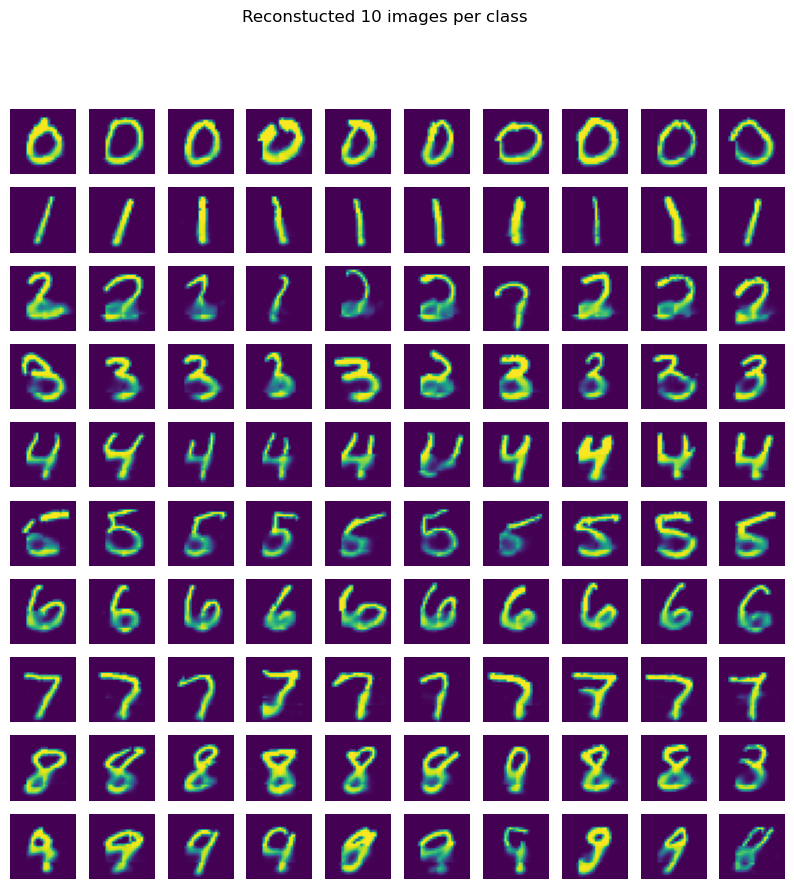

In [27]:
recons_imgs = []
for i in range(len(test_data_reduced)): # len(test_data_reduced)
    img = imageReconstruction(test_data_reduced[i,0:8,:])
    recons_imgs.append(img)

plt.figure(figsize=(10, 10))
plt.suptitle('Reconstucted 10 images per class')

for i in range(10):
    for j in range(10):
        ax=plt.subplot2grid((10, 10), (i, j))
        ax.imshow(recons_imgs[i*10+j])
        plt.axis('off')

### Observation

The highlighted red images depict instances where the model made incorrect predictions. However, these errors seem deliberate and could easily confuse a person as well.

![Image](Q1edited.png)